# Model_XGBoost

In [2]:
import s3fs
import time
import numpy as np
import pandas as pd

import nltk
import xgboost as xgb

from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [ ]:
# helper function for model evaluation
def eval(X_train, X_test, y_train, y_test, model):
    dtrain_pred = model.predict(X_train)
    dtrain_predprob = model.predict_proba(X_train)[:,1]
    dtest_pred = model.predict(X_test)
    dtest_predprob = model.predict_proba(X_test)[:,1]
    measure = metrics.precision_recall_fscore_support(y_test, dtest_pred, 
                                                      beta=1.0, labels=None, 
                                                      pos_label=1, average='binary')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_pred))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtest_pred))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))
    print("Confusion Matrix (Actual X Pred) :\n", metrics.confusion_matrix(y_test, dtest_pred))
    print ("Precision : %f" % measure[0])
    print("Recall : %f"  % measure[1])

In [ ]:
dtrain = pd.read_csv(f's3://cortex-ni-wc-claims/WC_DeEscl_Data_Build_wClstr_v2_dtrain.csv')
dtest = pd.read_csv(f's3://cortex-ni-wc-claims/WC_DeEscl_Data_Build_wClstr_v2_dtest.csv')

In [ ]:
X_train_onehot = dtrain.iloc[:, :-1]
y_train = dtrain.iloc[:, -1]
X_test_onehot = dtest.iloc[:, :-1]
y_test = dtest.iloc[:, -1]

## Train Model

In [34]:
train_dmatrix = xgb.DMatrix(data=X_train_onehot,label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test_onehot,label=y_test)

/mnt/miniconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/mnt/miniconda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Base XGB Model

In [3]:
# bucket = 's3://cortex-ni-wc-claims'
# file = 'WC_DeEscl_Modeldf_v2.csv'

dtrain = pd.read_csv(f's3://cortex-ni-wc-claims/WC_DeEscl_Data_Build_wClstr_v2_dtrain.csv')
dtest = pd.read_csv(f's3://cortex-ni-wc-claims/WC_DeEscl_Data_Build_wClstr_v2_dtest.csv')
# print('Data shape: ', df.shape)

In [6]:
X_train_onehot = dtrain.iloc[:, :-1]
y_train = dtrain.iloc[:, -1]

X_test_onehot = dtest.iloc[:, :-1]
y_test = dtest.iloc[:, -1]

print(X_train_onehot.shape)
print(X_test_onehot.shape)
print(y_train.shape)
print(y_test.shape)

(326717, 617)
(217812, 617)
(326717,)
(217812,)


In [10]:
clf = xgb.load('xgb1.model')

AttributeError: module 'xgboost' has no attribute 'load'

In [11]:
params = {'objective':'binary:logistic',
          'learning_rate': 0.1,
          'alpha': 10,
          'n_estimators': 500,
          'max_depth': 2, 
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.3,
          'gamma':0,
          'scale_pos_weight': 1,
          'seed': 123,
          'verbose_eval': 50,
          'n_job': 7}

In [13]:
import time
start_time = time.time()

clf = xgb.XGBClassifier(**params)
clf.fit(X_train_onehot, y_train,
        eval_set=[(X_train_onehot, y_train), (X_test_onehot, y_test)],
        eval_metric='auc',
       early_stopping_rounds=10)

evals_result = clf.evals_result()
print("--- %s seconds ---" % (time.time() - start_time))   

[0]	validation_0-auc:0.640335	validation_1-auc:0.642551
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.671141	validation_1-auc:0.672122
[2]	validation_0-auc:0.676169	validation_1-auc:0.675864
[3]	validation_0-auc:0.685573	validation_1-auc:0.684244
[4]	validation_0-auc:0.688475	validation_1-auc:0.687284
[5]	validation_0-auc:0.693597	validation_1-auc:0.692203
[6]	validation_0-auc:0.703454	validation_1-auc:0.701756
[7]	validation_0-auc:0.71271	validation_1-auc:0.711024
[8]	validation_0-auc:0.711628	validation_1-auc:0.709822
[9]	validation_0-auc:0.716425	validation_1-auc:0.714504
[10]	validation_0-auc:0.717516	validation_1-auc:0.715542
[11]	validation_0-auc:0.723233	validation_1-auc:0.721204
[12]	validation_0-auc:0.725493	validation_1-auc:0.723503
[13]	validation_0-auc:0.727834	validation_1-auc:0.725694
[14]	validation_0-auc:0.727976	validation_1-auc:0.725908

In [14]:
dtrain_pred = clf.predict(X_train_onehot)
dtrain_predprob = clf.predict_proba(X_train_onehot)[:,1]
dtest_pred= clf.predict(X_test_onehot)
dtest_predprob = clf.predict_proba(X_test_onehot)[:,1]

#Print model report:
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_pred))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtest_pred))
print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))


Model Report
Accuracy : 0.7676
AUC Score (Train): 0.789498
Accuracy : 0.766
AUC Score (Test): 0.786278


In [16]:
metrics.confusion_matrix(y_test, dtest_pred)
# rows actual
# cols pred

array([[ 18530,  40371],
       [ 10606, 148305]])

In [18]:
metrics.precision_recall_fscore_support(y_test, dtest_pred, beta=1.0, labels=None, pos_label=1, average='binary')
#precision, recall, fbeta

(0.7860300197163391, 0.9332582388884344, 0.8533403147988848, None)

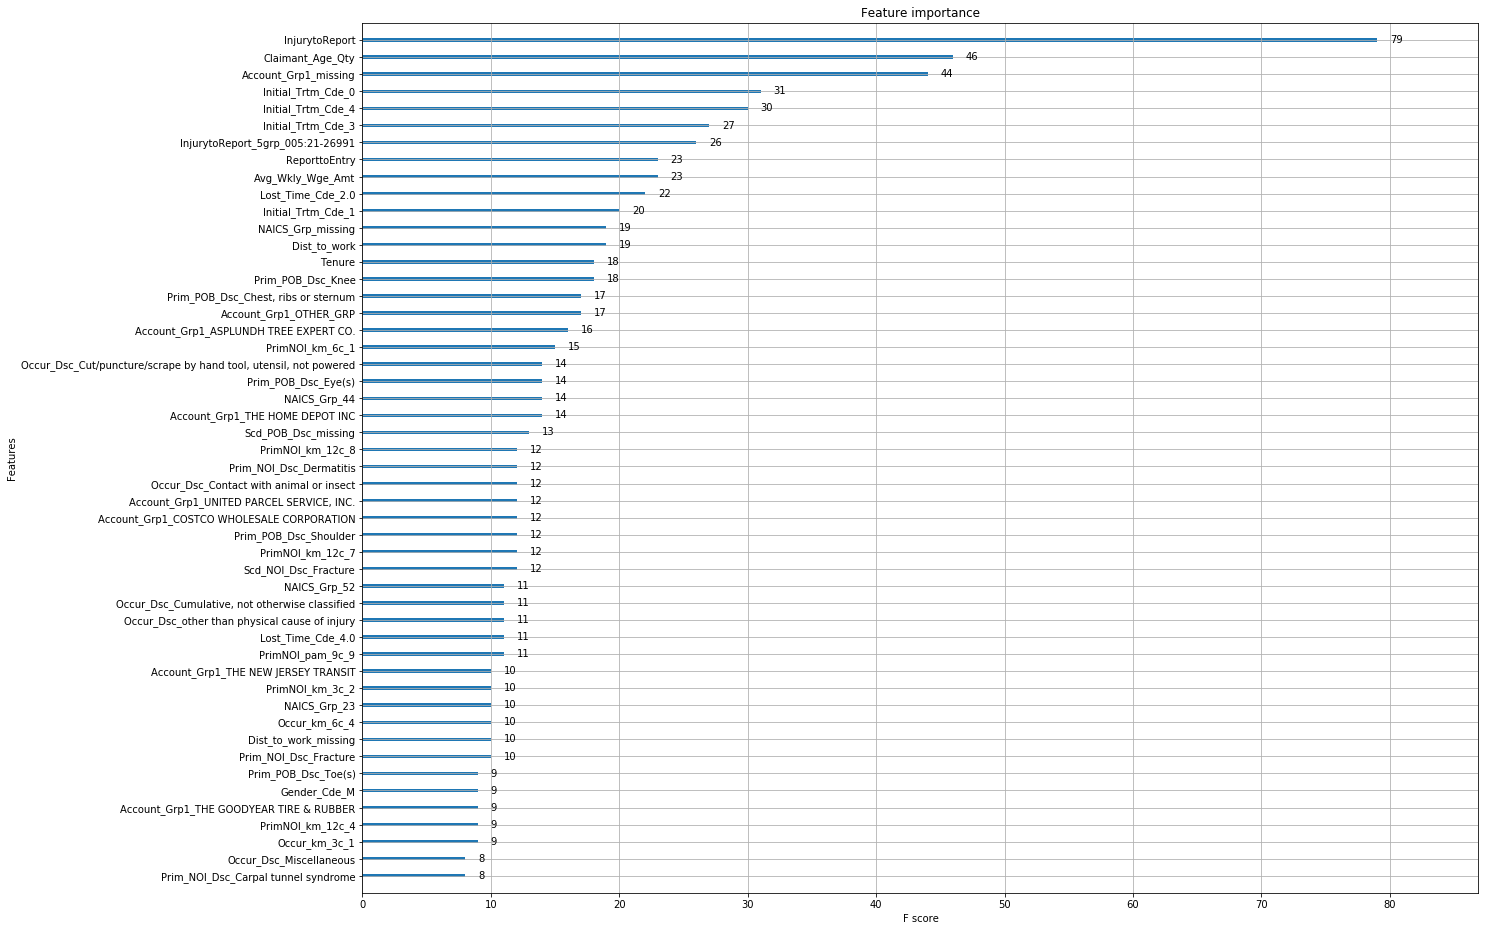

In [19]:
fig, ax = plt.subplots(1,1,figsize=(20,16))
xgb.plot_importance(clf,  max_num_features=50, ax=ax)

In [21]:
# clf.save_model('xgb1.model')
import pickle
from sklearn.externals import joblib

#save model
joblib.dump(clf, 'xgb1.pkl') 
# # load model
# clf_load = joblib.load('xgb1.pkl') 

### Fine Tunning

#### 1. Select n_estimators

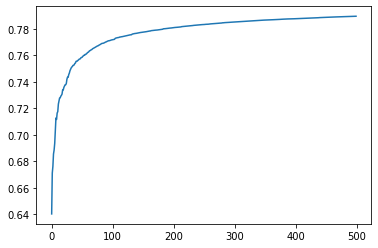

In [33]:
# train
plt.plot(range(500), evals_result['validation_0']['auc'])

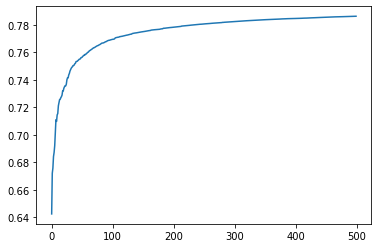

In [34]:
# test
plt.plot(range(500), evals_result['validation_1']['auc'])

After checking the auc imporvement rate on both train and test, it seems fitting 100 trees may be sufficient in fine tunning the model, such that it will save more than half of the training time from fitting 500 trees each round.  

**Notes: fine tunning work is conituned in a different ipynb located on a more powerful EC2 instance!**